# Spatial Weights

In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm_notebook
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
from datetime import date, timedelta


import itertools

import os
data_path = os.path.join('/','home','fterroso','data','Spain-INE-mobility-study-2020')

import libpysal as lps
from libpysal.weights import Queen, Rook, KNN, Kernel, DistanceBand

import contextily as cx

import dask

/home/fterroso/python/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
/home/fterroso/python/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from splot.libpysal import plot_spatial_weights

In [3]:
zones_gdf = gpd.read_file(os.path.join(data_path,'zonificacion','distritos_mitma.shp'))

In [4]:
zones_gdf.head()

,ID,geometry
0,2408910,"POLYGON ((290940.137 4719080.203, 290956.704 4..."
1,22117_AM,"POLYGON ((774184.362 4662152.523, 774452.348 4..."
2,2305009,"POLYGON ((429744.982 4179976.538, 429716.997 4..."
3,07058_AM,"POLYGON ((1000859.396 4415059.160, 1000625.088..."
4,2305006,"POLYGON ((429795.125 4180956.539, 429860.816 4..."


In [5]:
zones_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2850 entries, 0 to 2849
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   ID        2850 non-null   object  
 1   geometry  2850 non-null   geometry
dtypes: geometry(1), object(1)
memory usage: 44.7+ KB


In [6]:
trips_data = pd.read_csv(os.path.join('data','trips_time_series_all_inter.csv'),index_col=0)

In [7]:
trips_data.head()

,20200221_00,20200221_01,20200221_02,20200221_03,20200221_04,20200221_05,20200221_06,20200221_07,20200221_08,20200221_09,...,20201130_14,20201130_15,20201130_16,20201130_17,20201130_18,20201130_19,20201130_20,20201130_21,20201130_22,20201130_23
01001_AM,291.654,129.650,123.822,280.810,282.418,518.179,736.074,1253.000,981.544,893.510,...,1307.238,1026.083,1073.847,1147.206,650.740,648.024,563.314,735.201,258.461,230.591
01002,192.529,149.992,50.547,73.097,208.114,616.786,732.075,779.587,638.112,734.767,...,701.593,598.760,615.822,826.882,580.843,378.512,381.695,407.566,124.729,106.744
01010_AM,92.726,50.822,37.895,19.586,91.560,396.531,457.180,591.326,516.919,471.008,...,495.460,610.121,559.796,476.880,354.807,215.711,216.593,277.574,119.830,52.331
01031_AM,97.674,64.901,92.150,62.669,109.056,208.462,469.924,691.565,645.793,789.906,...,1085.613,628.526,682.578,582.456,603.958,344.157,286.541,269.655,159.443,118.029
01036,173.565,118.227,204.784,219.318,409.485,779.103,1091.613,969.506,845.084,875.701,...,1070.542,815.612,681.116,746.917,704.784,413.711,441.988,575.437,319.760,68.968


In [8]:
trips_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2844 entries, 01001_AM to 20903
Columns: 6815 entries, 20200221_00 to 20201130_23
dtypes: float64(6815)
memory usage: 147.9+ MB


In [9]:
zones_gdf = zones_gdf[zones_gdf['ID'].isin(trips_data.index.tolist())]

In [10]:
zones_gdf.shape

(2844, 2)

## General functions

In [11]:
e_date = datetime.datetime.strptime('2020-11-30', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-02-21', '%Y-%m-%d')

In [12]:
def read_INE_trips_date_fn(date_, trips_type='all'):
    date_str= date_.strftime('%Y%m%d')
    df_date= df.read_csv(os.path.join(data_path, 'muestra1', f'{date_str}_maestra_1_mitma_distrito.txt'), 
                             sep='|',dtype={'origen':str, 'destino':str,'fecha':str, 'periodo':str})
    
    if trips_type=='inter':
        df_date= df_date[df_date['origen']!=df_date['destino']] #only keep trips between areas
    elif trips_type=='intra':
        df_date= df_date[df_date['origen']==df_date['destino']] #only keep trips within the areas
    
    #convert period column to a two-digit string
    df_date['periodo'] = df_date['periodo'].apply(lambda x: x.zfill(2))
    df_date= df_date.fillna(0) # set nan as 0
    return df_date

In [13]:
def generate_days_fn(init_date, final_date):
    
    delta = final_date - init_date       # as timedelta

    target_days = []
    for i in range(delta.days + 1):
        day = init_date + timedelta(days=i)
        target_days.append(day)
    
    return target_days

In [14]:
def add_total_values_fn(trips_df_):
    trips_df_['total'] = trips_df_.sum(axis=1) # column with total number of trips per area
    trips_df_.loc['total'] = trips_df_.sum(axis=0) # row with total number of trips per day
    return trips_df_

## Queens neighborhood

In [15]:
qW = Queen.from_dataframe(zones_gdf)

/home/fterroso/python/lib/python3.6/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 16 disconnected components.
 There are 4 islands with ids: 1113, 1139, 1278, 1427.
  warnings.warn(message)


In [16]:
qW_ids = Queen.from_dataframe(zones_gdf, idVariable='ID')

/home/fterroso/python/lib/python3.6/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 16 disconnected components.
 There are 4 islands with ids: 07024, 17094, 36901, 38036_AM.
  warnings.warn(message)


In [17]:
qW.full()[0].shape

(2844, 2844)

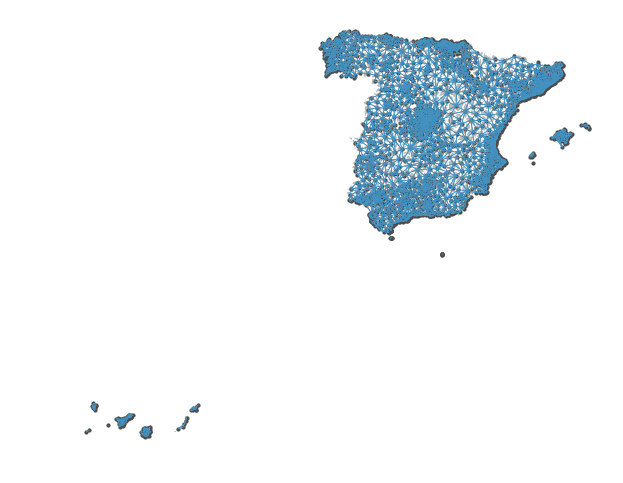

In [18]:
plot_spatial_weights(qW, zones_gdf);

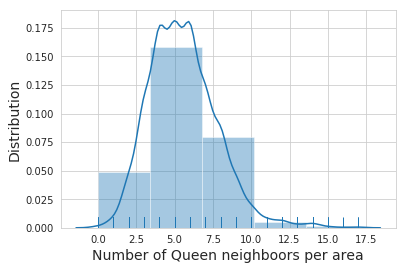

In [19]:
sns.set_style("whitegrid")
ax=sns.distplot(pd.Series(qW.cardinalities), bins=5, rug=True);
ax.set_ylabel('Distribution')
ax.set_xlabel('Number of Queen neighboors per area')
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
plt.savefig(os.path.join('figs','queen_cardinalities_distribution.png'))

## Spatial autocorrelation

In [20]:
all_trips = pd.read_csv(os.path.join('data','trips_time_series_all.csv'),index_col=0)
all_trips= all_trips.fillna(0)
all_trips = add_total_values_fn(all_trips)

In [21]:
all_trips.head()

,20200221_00,20200221_01,20200221_02,20200221_03,20200221_04,20200221_05,20200221_06,20200221_07,20200221_08,20200221_09,...,20201130_15,20201130_16,20201130_17,20201130_18,20201130_19,20201130_20,20201130_21,20201130_22,20201130_23,total
01001_AM,351.569,151.978,170.314,304.908,366.064,612.043,792.522,1347.836,1078.382,1083.844,...,1223.343,1269.692,1264.783,826.047,742.421,673.619,848.775,348.361,338.776,5147442.407
01002,307.557,299.509,234.590,119.108,402.865,776.728,900.781,1033.930,894.766,1088.407,...,1037.809,970.586,1289.262,1075.365,780.131,715.145,732.227,452.936,249.190,4319253.022
01010_AM,117.676,74.781,73.922,33.134,116.510,430.138,476.429,630.298,552.545,517.019,...,656.945,582.302,536.971,433.186,305.935,302.467,320.358,200.024,79.813,2373124.943
01031_AM,124.948,107.608,110.947,82.437,150.341,222.748,541.171,915.834,773.469,907.130,...,857.127,823.528,784.795,693.835,446.964,355.163,321.990,166.776,143.830,4032748.814
01036,515.327,232.868,372.743,436.898,586.419,1066.202,1589.005,1448.471,1420.790,1687.426,...,1385.129,1420.070,1458.191,1512.568,1270.918,1192.500,963.190,748.999,307.763,6960916.699


In [22]:
zones_gdf = zones_gdf.set_index('ID')
zones_gdf['n_trips'] = all_trips['total']

In [23]:
zones_gdf.head()

,geometry,n_trips
ID,,
2408910,"POLYGON ((290940.137 4719080.203, 290956.704 4...",6020624.818
22117_AM,"POLYGON ((774184.362 4662152.523, 774452.348 4...",2623196.900
2305009,"POLYGON ((429744.982 4179976.538, 429716.997 4...",3778178.501
07058_AM,"POLYGON ((1000859.396 4415059.160, 1000625.088...",4161969.734
2305006,"POLYGON ((429795.125 4180956.539, 429860.816 4...",4798684.013


In [24]:
wq =  lps.weights.Queen.from_dataframe(zones_gdf)
wq.transform = 'r'

('WARNING: ', 1113, ' is an island (no neighbors)')
('WARNING: ', 1139, ' is an island (no neighbors)')
('WARNING: ', 1278, ' is an island (no neighbors)')
('WARNING: ', 1427, ' is an island (no neighbors)')


/home/fterroso/python/lib/python3.6/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 16 disconnected components.
 There are 4 islands with ids: 1113, 1139, 1278, 1427.
  warnings.warn(message)


In [25]:
y = zones_gdf['n_trips']
ylag = lps.weights.lag_spatial(wq, y)

### Generate ylag adjacency matrix

In [26]:
ylag

array([10141219.82325   ,  4629567.935     ,  4470325.1095    , ...,
        2348842.87983333,  3223913.0805    , 15866046.65583333])

In [27]:
len(ylag)

2844

In [28]:
ylag_diff = np.array([abs(i-j) for i in ylag for j in ylag])

In [29]:
ylag_diff= ylag_diff.reshape(2844,2844)

In [30]:
ylag_diff.shape

(2844, 2844)

In [31]:
y_lagdiff_df = pd.DataFrame(ylag_diff, columns=zones_gdf.index, index=zones_gdf.index)

In [32]:
y_lagdiff_df.head()

ID,2408910,22117_AM,2305009,07058_AM,2305006,2305005,2305004,2305003,2305002,2305001,...,15073,1303404,15071,02045_AM,43176_AM,31010_AM,08016_AM,45037_AM,06050_AM,50182
ID,,,,,,,,,,,,,,,,,,,,,
2408910,0.000000e+00,5.511652e+06,5.670895e+06,3.148096e+06,1.114888e+06,2.981452e+06,2.604509e+06,3.549577e+06,2.381896e+06,6.906837e+06,...,2.808122e+06,2.781872e+05,8.147324e+05,4.695583e+06,5.514754e+06,6.783925e+06,6.550193e+06,7.792377e+06,6.917307e+06,5.724827e+06
22117_AM,5.511652e+06,0.000000e+00,1.592428e+05,2.363556e+06,4.396764e+06,2.530199e+06,2.907143e+06,1.962075e+06,3.129756e+06,1.395185e+06,...,2.703530e+06,5.789839e+06,6.326384e+06,8.160686e+05,3.102237e+03,1.272273e+06,1.038541e+06,2.280725e+06,1.405655e+06,1.123648e+07
2305009,5.670895e+06,1.592428e+05,0.000000e+00,2.522799e+06,4.556007e+06,2.689442e+06,3.066386e+06,2.121317e+06,3.288999e+06,1.235943e+06,...,2.862773e+06,5.949082e+06,6.485627e+06,9.753114e+05,1.561406e+05,1.113030e+06,8.792982e+05,2.121482e+06,1.246412e+06,1.139572e+07
07058_AM,3.148096e+06,2.363556e+06,2.522799e+06,0.000000e+00,2.033208e+06,1.666435e+05,5.435871e+05,4.014814e+05,7.661999e+05,3.758741e+06,...,3.399742e+05,3.426283e+06,3.962828e+06,1.547487e+06,2.366658e+06,3.635829e+06,3.402097e+06,4.644281e+06,3.769211e+06,8.872923e+06
2305006,1.114888e+06,4.396764e+06,4.556007e+06,2.033208e+06,0.000000e+00,1.866564e+06,1.489621e+06,2.434689e+06,1.267008e+06,5.791949e+06,...,1.693234e+06,1.393075e+06,1.929620e+06,3.580695e+06,4.399866e+06,5.669037e+06,5.435305e+06,6.677489e+06,5.802419e+06,6.839715e+06


In [33]:
y_lagdiff_df.tail()

ID,2408910,22117_AM,2305009,07058_AM,2305006,2305005,2305004,2305003,2305002,2305001,...,15073,1303404,15071,02045_AM,43176_AM,31010_AM,08016_AM,45037_AM,06050_AM,50182
ID,,,,,,,,,,,,,,,,,,,,,
31010_AM,6.783925e+06,1.272273e+06,1.113030e+06,3.635829e+06,5.669037e+06,3.802473e+06,4.179416e+06,3.234348e+06,4.402029e+06,1.229122e+05,...,3.975803e+06,7.062112e+06,7.598657e+06,2.088342e+06,1.269171e+06,0.000000e+00,2.337322e+05,1.008452e+06,1.333817e+05,1.250875e+07
08016_AM,6.550193e+06,1.038541e+06,8.792982e+05,3.402097e+06,5.435305e+06,3.568741e+06,3.945684e+06,3.000616e+06,4.168297e+06,3.566443e+05,...,3.742071e+06,6.828380e+06,7.364925e+06,1.854610e+06,1.035439e+06,2.337322e+05,0.000000e+00,1.242184e+06,3.671138e+05,1.227502e+07
45037_AM,7.792377e+06,2.280725e+06,2.121482e+06,4.644281e+06,6.677489e+06,4.810925e+06,5.187868e+06,4.242800e+06,5.410481e+06,8.855397e+05,...,4.984255e+06,8.070564e+06,8.607109e+06,3.096794e+06,2.277623e+06,1.008452e+06,1.242184e+06,0.000000e+00,8.750702e+05,1.351720e+07
06050_AM,6.917307e+06,1.405655e+06,1.246412e+06,3.769211e+06,5.802419e+06,3.935854e+06,4.312798e+06,3.367729e+06,4.535411e+06,1.046952e+04,...,4.109185e+06,7.195494e+06,7.732039e+06,2.221723e+06,1.402553e+06,1.333817e+05,3.671138e+05,8.750702e+05,0.000000e+00,1.264213e+07
50182,5.724827e+06,1.123648e+07,1.139572e+07,8.872923e+06,6.839715e+06,8.706279e+06,8.329336e+06,9.274404e+06,8.106723e+06,1.263166e+07,...,8.532949e+06,5.446640e+06,4.910094e+06,1.042041e+07,1.123958e+07,1.250875e+07,1.227502e+07,1.351720e+07,1.264213e+07,0.000000e+00


In [34]:
y_lagdiff_df.to_csv(os.path.join('data', 'ylag_adjacency_matrix.csv'))

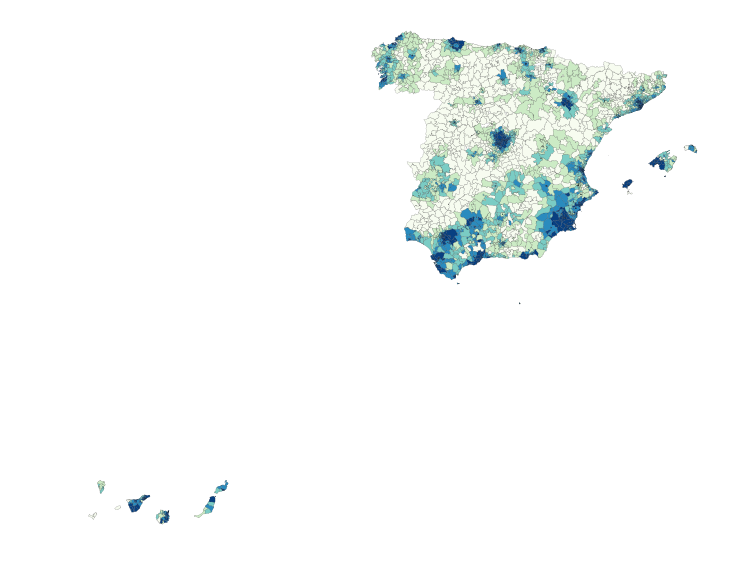

In [35]:
f, ax = plt.subplots(1, figsize=(12, 12))

zones_gdf.assign(cl=ylag).plot(column='cl', scheme='quantiles', \
        k=5, cmap='GnBu', linewidth=0.1, ax=ax, \
        edgecolor='black')

#cx.add_basemap(ax, crs=zones_gdf.crs.to_string(), source=cx.providers.Stamen.TonerLite)
ax.axis('off')
plt.savefig(os.path.join('figs', 'spatial_autocorrelation_num_of_trips.png'))

## Generate queen-adj + GM matrix

In [67]:
gm_matrix_df = pd.read_csv(os.path.join('data', 'gravity_model_adjacency_matrix.csv'), index_col=0)

In [68]:
gm_matrix_df = gm_matrix_df.loc[trips_data.index.tolist(),trips_data.index.tolist()]

In [69]:
gm_matrix_df.head()

,01001_AM,01002,01010_AM,01031_AM,01036,01043_AM,01047_AM,01051,01058_AM,0105901,...,5200108,24183_AM,50165_AM,20052_AM,33072_AM,38013_AM,05220_AM,40149_AM,31092_AM,20903
01001_AM,0.000000e+00,1.218678e+06,5.615584e+05,1.115931e+06,1.955315e+06,1.813590e+06,3.896523e+05,4.422408e+06,1.275232e+06,1.106341e+07,...,195025.303678,137060.695071,135372.065105,629288.456378,123112.537787,15509.044622,89954.792013,131247.885296,277414.751212,5.763876e+05
01002,1.218678e+06,0.000000e+00,3.820728e+06,1.097560e+06,1.139711e+07,9.908613e+05,1.198984e+06,7.150693e+05,1.141813e+06,9.763433e+06,...,265738.109252,240117.566457,162270.196761,469896.772553,200523.710095,21688.731423,130604.663552,190572.749294,271063.171898,5.406953e+05
01010_AM,5.615584e+05,3.820728e+06,0.000000e+00,5.162764e+05,8.715903e+06,4.691215e+05,5.370344e+05,3.351859e+05,4.831988e+05,4.039202e+06,...,149985.963381,143906.796232,89273.473606,240243.966616,118410.468634,12355.956831,73928.089056,106475.476648,145318.441885,2.880366e+05
01031_AM,1.115931e+06,1.097560e+06,5.162764e+05,0.000000e+00,1.628658e+06,1.968359e+06,5.153257e+05,7.541682e+05,5.634365e+05,8.009985e+06,...,206018.792849,150523.427455,138052.370108,312266.073101,131486.480159,16028.998688,103206.912917,162585.015376,226587.526904,3.626131e+05
01036,1.955315e+06,1.139711e+07,8.715903e+06,1.628658e+06,0.000000e+00,1.545570e+06,1.447096e+06,1.151958e+06,1.797188e+06,1.361503e+07,...,474646.987513,434652.417611,287172.278275,861339.062929,365017.783608,39145.728064,229105.459081,326807.893660,485154.663831,1.010814e+06


In [70]:
top_n=100
top_gm_df =pd.DataFrame({n: gm_matrix_df.T[col].nlargest(top_n).index.tolist() 
                  for n, col in enumerate(gm_matrix_df.T)}).T
top_gm_df.index = trips_data.index.tolist()

In [71]:
top_gm_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
01001_AM,0105902,0105903,0105905,0105901,0105904,2608904,4802005,20055,2608902,4802006,...,20902,3907508,31097,5029705,2807914,20017,42173,31232,01043_AM,3120105
01002,4802005,0105902,4802007,4802006,4802001,0105905,48015,0105903,01036,48078,...,48096,3120103,3907507,48026_AM,3120104,20079,3907502,2807914,0801909,3300401
01010_AM,4802005,4802007,4802006,4802001,01036,48015,48078,48082,4802004,4802008,...,0801907,0801908,48065_AM,2807918,48071_AM,3300401,48034,48094_AM,4801303,2807914
01031_AM,0105902,2608904,0105903,0105905,2608902,09219,0105901,0105904,2608903,2807908,...,5029702,48003,2807919,4718610,20079,2809204,0704004,20071,28047,2006904
01036,4802005,4802007,4802006,48015,4802001,4802004,4802008,48078,48082,48036,...,48905_AM,48090,5029704,0801907,2810601,0801908,48071_AM,3907507,3907502,48904_AM


In [72]:
top_gm_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
38013_AM,3800601,38048,3501604,38001,38017,3501602,3501603,3501601,38026,3502203,...,2906708,3802304,4109104,35015,2906710,2807918,3803802,38009,38015_AM,38051
05220_AM,2807911,2807908,2807910,2807913,2807915,2807916,2807906,2807902,2807920,2807904,...,28131,37246,2804902,4109104,2805804,2906707,0905909,47076,45081,28176
40149_AM,2807908,2807911,2807910,2807913,2807915,2807916,2807906,2807920,2807902,2807905,...,2804902,2807401,47010,3412005,28152,2814804,2800503,2608902,5029705,0704004
31092_AM,3120107,5029710,3120103,0801902,3120104,0801910,5029703,2807911,2807908,2807910,...,48027,0905909,09219,2608903,31019_AM,20902,31903,20036,42173,4802008
20903,2006903,2006907,20067,2006906,2006904,20040,2006905,20902,2004503,20064,...,4802003,0905905,2810601,09219,20017,20076,48084,39020_AM,5029705,4802002


In [73]:
qW = Queen.from_dataframe(zones_gdf)
q_matrix_ = qW.full()[0]

/home/fterroso/python/lib/python3.6/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 16 disconnected components.
 There are 4 islands with ids: 1113, 1139, 1278, 1427.
  warnings.warn(message)


In [74]:
q_matrix_df = pd.DataFrame(q_matrix_, index=trips_data.index.tolist(), columns=trips_data.index.tolist())

In [75]:
q_matrix_df

,01001_AM,01002,01010_AM,01031_AM,01036,01043_AM,01047_AM,01051,01058_AM,0105901,...,5200108,24183_AM,50165_AM,20052_AM,33072_AM,38013_AM,05220_AM,40149_AM,31092_AM,20903
01001_AM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01010_AM,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01031_AM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01036,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38013_AM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05220_AM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40149_AM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31092_AM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
q_matrix_.shape

(2844, 2844)

In [80]:
for row in top_gm_df.iterrows():
    t_area = row[0]
    for area in row[1].values:
        q_matrix_df.loc[t_area, area]= 1

In [82]:
q_matrix_df.head()

,01001_AM,01002,01010_AM,01031_AM,01036,01043_AM,01047_AM,01051,01058_AM,0105901,...,5200108,24183_AM,50165_AM,20052_AM,33072_AM,38013_AM,05220_AM,40149_AM,31092_AM,20903
01001_AM,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01002,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01010_AM,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01031_AM,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01036,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
q_matrix_df.to_csv(os.path.join('data', 'queen_gravity_model_adjacency_matrix.csv'))

## Generate trips connectivity plots

In [ ]:
import dask.dataframe as dd

In [ ]:
from dask.distributed import Client, progress
client = Client(threads_per_worker=1, n_workers=12)
client

In [ ]:
e_date = datetime.datetime.strptime('2020-11-30', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-02-21', '%Y-%m-%d')

In [ ]:
@dask.delayed
def read_INE_trips_date_dask_fn(date_, trips_type='all'):
    date_str= date_.strftime('%Y%m%d')
    df_date= dd.read_csv(os.path.join(data_path, 'muestra1', f'{date_str}_maestra_1_mitma_distrito.txt'), 
                             sep='|',dtype={'origen':str, 'destino':str,'fecha':str, 'periodo':str})
    
    if trips_type=='inter':
        df_date= df_date[df_date['origen']!=df_date['destino']] #only keep trips between areas
    elif trips_type=='intra':
        df_date= df_date[df_date['origen']==df_date['destino']] #only keep trips within the areas
    
    #convert period column to a two-digit string
    #df_date['periodo'] = df_date['periodo'].apply(lambda x: x.zfill(2))
    
    df_date= df_date.drop(columns=['edad', 'viajes_km','residencia'])
  
    df_date= df_date.fillna(0)#.compute() # set nan as 0
    return df_date

In [ ]:
@dask.delayed
def calculate_adjacency_trips_for_id_fn(df_id,adjacent_areas):
    adjacent_trips= date_id_df[date_id_df['destino'].isin(adjacent_areas)]['viajes'].sum()
    non_adjacent_trips = date_id_df[~date_id_df['destino'].isin(adjacent_areas)]['viajes'].sum()
        
    return (adjacent_trips,non_adjacent_trips)

In [ ]:
def calculate_adjacency_trips_fn(df, adj_matrix):
    result = []
    ids = df['origen'].unique()
    for id_ in ids:
        adjacent_areas = list(adj_matrix[id_].keys())
        date_id_df =df[df['origen']==id_]
        
        adjacent_trips= date_id_df[date_id_df['destino'].isin(adjacent_areas)]['viajes'].sum()        
        non_adjacent_trips = date_id_df[~date_id_df['destino'].isin(adjacent_areas)]['viajes'].sum()
        
        result.append((id_,'adj_trips', adjacent_trips))
        result.append((id_,'n_adj_trips',non_adjacent_trips))
    
    return result

In [ ]:
@dask.delayed
def merge_adjacency_results_fn(results):
    df= pd.DataFrame.from_records(results,columns='id adjacent_trips non_adjacent_trips'.split())
    df = df.set_index('id')
    return df

In [ ]:
def generate_adjacency_stats_fn(date_, adj_matrix):
    date_df= read_INE_trips_date_dask_fn(date_)
    partition_df = date_df.to_delayed()
    delayed_values = [dask.delayed(calculate_adjacency_trips_fn)(part,adj_matrix) for part in partition_df.compute()]
    #result = calculate_adjacency_trips_fn(date_df,adj_matrix)
    #result_df = merge_adjacency_results_fn(delayed_values)
    #df= pd.DataFrame.from_records(result,columns='id adjacent_trips non_adjacent_trips'.split())
    return delayed_values

In [ ]:
def merge_results_fn(lazy_results_):
    #values = []
    #values = [item for sublist in lazy_results_ for item in sublist
    
    return lazy_results_


In [ ]:
lazy_results = []
target_days = generate_days_fn(i_date, e_date)
for date in tqdm_notebook(target_days): 
    lazy_result = dask.delayed(generate_adjacency_stats_fn)(date, qW_ids)
    lazy_results.append(lazy_result)

In [ ]:
results = dask.compute(*lazy_results)

In [ ]:
total = dask.delayed(merge_results_fn)(results)

In [ ]:
#total.visualize()

In [ ]:
values = total.compute()

In [ ]:
def aggregate_adjacent_trips_data_fn(values):
    values_lev1 = [item for sublist in values for item in sublist]
    values_lev2 = [item for sublist in values_lev1 for item in sublist]
    print(values_lev2[0])
    df = pd.DataFrame.from_records(values_lev2,columns='id trips_type n_trips'.split())
    return df.groupby(['id', 'trips_type']).sum()

In [ ]:
adj_df = aggregate_adjacent_trips_data_fn(values)

In [ ]:
adj_df.head()

In [ ]:
adj_df.to_csv(os.path.join('data','adj_trips.csv'))

In [ ]:
sns.set_style("whitegrid")
ax=sns.barplot(data=adj_df.reset_index(), x='trips_type', y='n_trips');
ax.set_ylabel('Number of trips');
ax.set_xlabel('Trip type');
plt.savefig(os.path.join('figs', 'trips_by_adjacency.png'))

In [ ]:
adj_df.head()

In [ ]:
norm_adj_df= adj_df / adj_df.groupby('id').sum('n_trips')

In [ ]:
sns.set_style("whitegrid")
ax=sns.barplot(data=norm_adj_df.reset_index(), x='trips_type', y='n_trips');
ax.set_ylabel('Rate of trips');
ax.set_xlabel('Trip type');
plt.savefig(os.path.join('figs', 'trips_by_adjacency_norm.png'))

## Test code

In [ ]:
df = read_INE_trips_date_dask_fn(datetime.datetime.strptime('2020-02-29', '%Y-%m-%d'), trips_type='inter')

In [ ]:
df.head()

In [ ]:
r = generate_adjacency_stats_fn(df)

In [ ]:
r.head()

In [ ]:
ids = df['origen'].unique()

In [ ]:
id_=ids[0]

In [ ]:
id_

In [ ]:
adjacent_areas = list(qW_ids[id_].keys())

In [ ]:
adjacent_areas

In [ ]:
date_id_df =df[df['origen']==id_]


In [ ]:
date_id_df.head()

In [ ]:
destinations = date_id_df['destino'].unique().tolist()

In [ ]:
destinations

In [ ]:
date_id_df[date_id_df['destino'].isin(adjacent_areas)]['viajes'].sum()

In [ ]:
date_id_df[~date_id_df['destino'].isin(adjacent_areas)]['viajes'].sum()